## TwoStep
This method will use a **2-step method** for **positive-unlabeled** classifier learning [(Kaboutari, et al. 2014)](https://www.semanticscholar.org/paper/An-Evaluation-of-Two-Step-Techniques-for-Learning-Kaboutari-Bagherzadeh/bd10ba5f30744e4755cbe7757e8c657ce5d6ec45)
1. Choose datapoints (droplets) that are confidently positive for the given label (in our case, empty droplets and dead cells)
2. Use some method of determining datapoints (droplets) that are confidently negative for the given label (we can use UMI ranking and MT enrichment of clusters)

In [1]:
import sys
sys.path.append('../')
# pipeline functions
from qc_pipeline import *
sc.settings.set_figure_params(dpi=80, color_map='viridis')

In [ ]:
# working
del sys.modules['qc_pipeline']
from qc_pipeline import *

### Load data and preprocess

In [2]:
s1 = sc.read_h5ad('../data/2771-AS-2-CTTGTA_S2.h5ad')
# see how many "good cells" Ken labeled (1)
s1.obs['ken_filter'].value_counts()

0    3721
1    1536
Name: ken_filter, dtype: int64

In [3]:
%%time
s1_thresh, rf = twostep_pipe(
    s1,
    clf = RandomForestClassifier(n_estimators=500, n_jobs=-1),
    mito_names='^mt-',
    n_hvgs=2000,
    thresh_method='li',
    obs_cols=[
        "arcsinh_n_genes_by_counts",
        "pct_counts_mito",
    ],
    directions=["above", "below"],
    pos_frac=0.7,
    neg_frac=0.3,
    seed=18,
)

Preprocessing counts and generating metrics


../QC.py:122: UserWarning: Encountered 10361 genes with 0 cells by counts. Consider removing these before proceeding (i.e. sc.pp.filter_genes(adata,min_cells=1))
  np.size(nt) - np.count_nonzero(nt)


Thresholding on heuristics for training labels
Generating sampling probabilities from arcsinh_n_genes_by_counts
Generating sampling probabilities from pct_counts_mito
Training two-step classifier:
Step 1 labeled 1034 new positives and 368 new negatives. 178 unlabeled remaining.
Iteration 1: Doing step 2... Step 1 labeled 24 new positives and 17 new negatives. 137 unlabeled remaining.
Iteration 2: Doing step 2... Step 1 labeled 16 new positives and 14 new negatives. 107 unlabeled remaining.
Iteration 3: Doing step 2... Step 1 labeled 1 new positives and 3 new negatives. 103 unlabeled remaining.
Iteration 4: Doing step 2... Step 1 labeled 2 new positives and 3 new negatives. 98 unlabeled remaining.
Iteration 5: Doing step 2... Step 1 labeled 2 new positives and 6 new negatives. 90 unlabeled remaining.
Iteration 6: Doing step 2... Done!
CPU times: user 5min 33s, sys: 3.9 s, total: 5min 37s
Wall time: 41.9 s


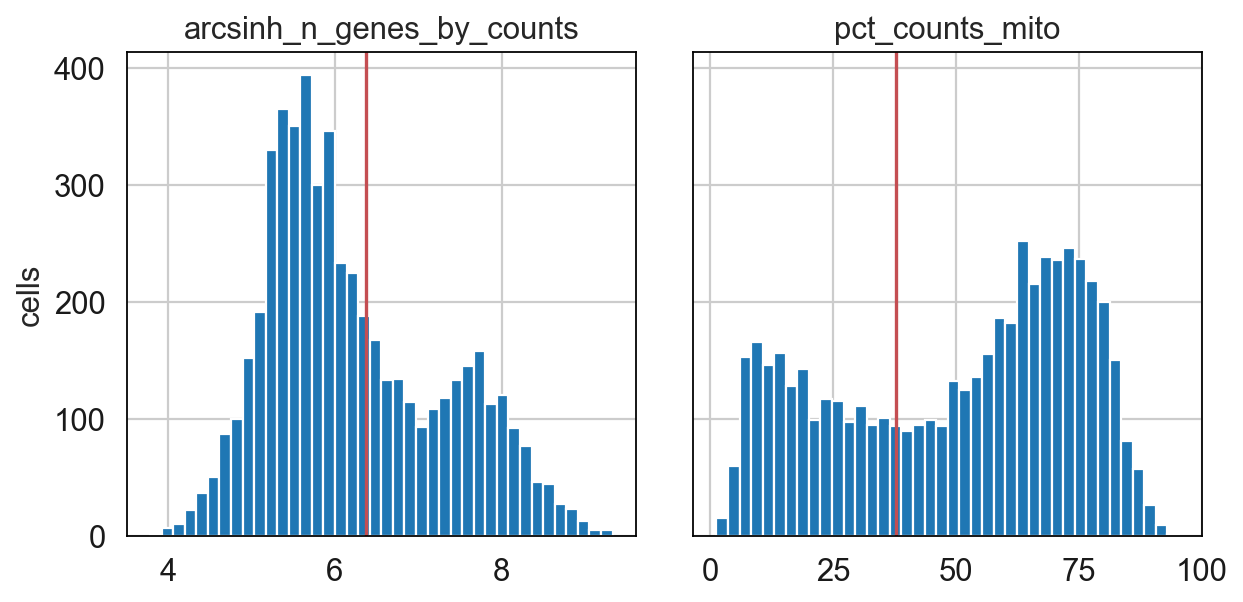

In [4]:
plot_thresh_obs(s1, s1_thresh)

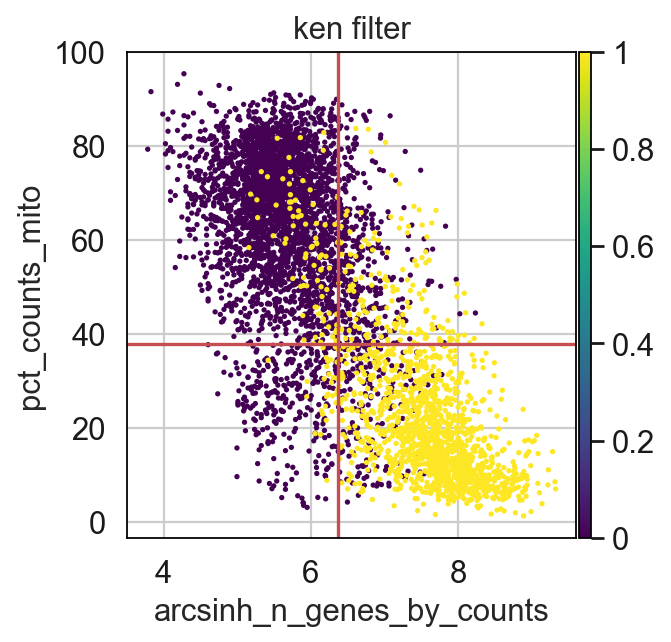

In [5]:
ax = sc.pl.scatter(adata=s1, x='arcsinh_n_genes_by_counts', y='pct_counts_mito', color='ken_filter', show=False)
ax.axhline(s1_thresh['pct_counts_mito'], color='r')
ax.axvline(s1_thresh['arcsinh_n_genes_by_counts'], color='r')
plt.show()

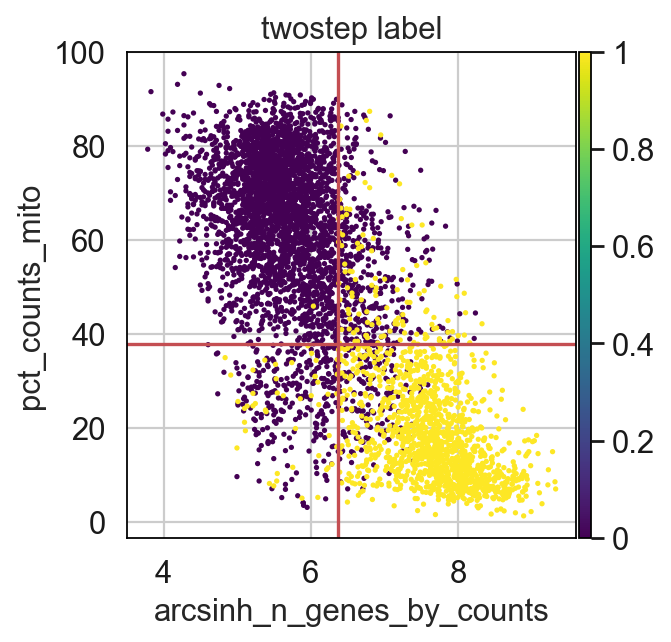

In [6]:
ax = sc.pl.scatter(adata=s1, x='arcsinh_n_genes_by_counts', y='pct_counts_mito', color='twostep_label', show=False)
ax.axhline(s1_thresh['pct_counts_mito'], color='r')
ax.axvline(s1_thresh['arcsinh_n_genes_by_counts'], color='r')
plt.show()

---
#### Now, reduce dimensions and see how embeddings/cell populations change between the two filterings (Ken and TwoStep)

In [7]:
# generate obs column with ken vs twostep for visualization
s1.obs['compare'] = 'neither'
s1.obs.loc[(s1.obs['ken_filter']==1) & (s1.obs['twostep_label']==1), 'compare'] = 'both'
s1.obs.loc[(s1.obs['ken_filter']==1) & (s1.obs['twostep_label']==0), 'compare'] = 'ken'
s1.obs.loc[(s1.obs['twostep_label']==1) & (s1.obs['ken_filter']==0), 'compare'] = 'twostep'

In [8]:
# create two new adata objects from ken and twostep filters
s1_ken = s1[s1.obs['ken_filter']==1,:].copy()
s1_twostep = s1[s1.obs['twostep_label']==1,:].copy()

In [9]:
# preprocess ken's dataset
s1_ken.X = s1_ken.layers['raw_counts'].copy()
sc.pp.filter_genes(s1_ken, min_cells=1)
recipe_fcc(s1_ken, X_final='arcsinh_norm', mito_names='^mt-')
s1_ken.obs['arcsinh_n_genes_by_counts'] = np.arcsinh(s1_ken.obs['n_genes_by_counts'])

... storing 'compare' as categorical


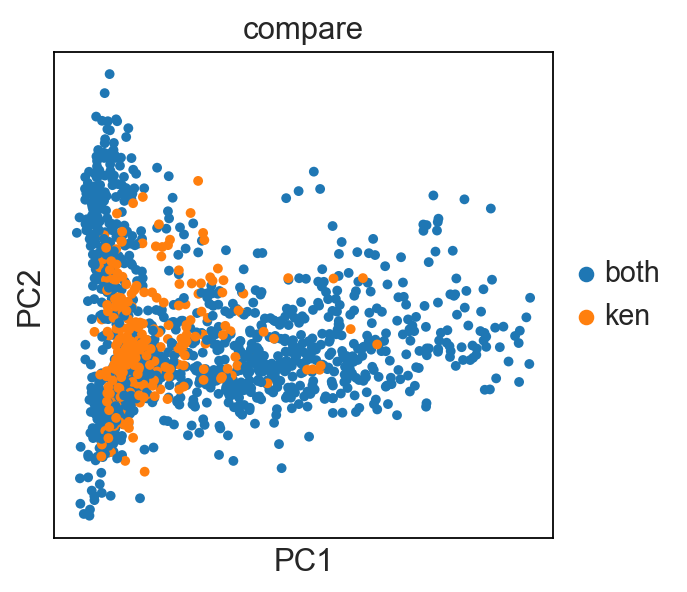

CPU times: user 1.42 s, sys: 324 ms, total: 1.74 s
Wall time: 300 ms


In [10]:
%%time
sc.tl.pca(s1_ken, n_comps=10)
sc.pl.pca(s1_ken, color=['compare'])

In [11]:
sc.pp.neighbors(s1_ken, n_neighbors=int(np.sqrt(s1_ken.n_obs)))
sc.tl.umap(s1_ken)

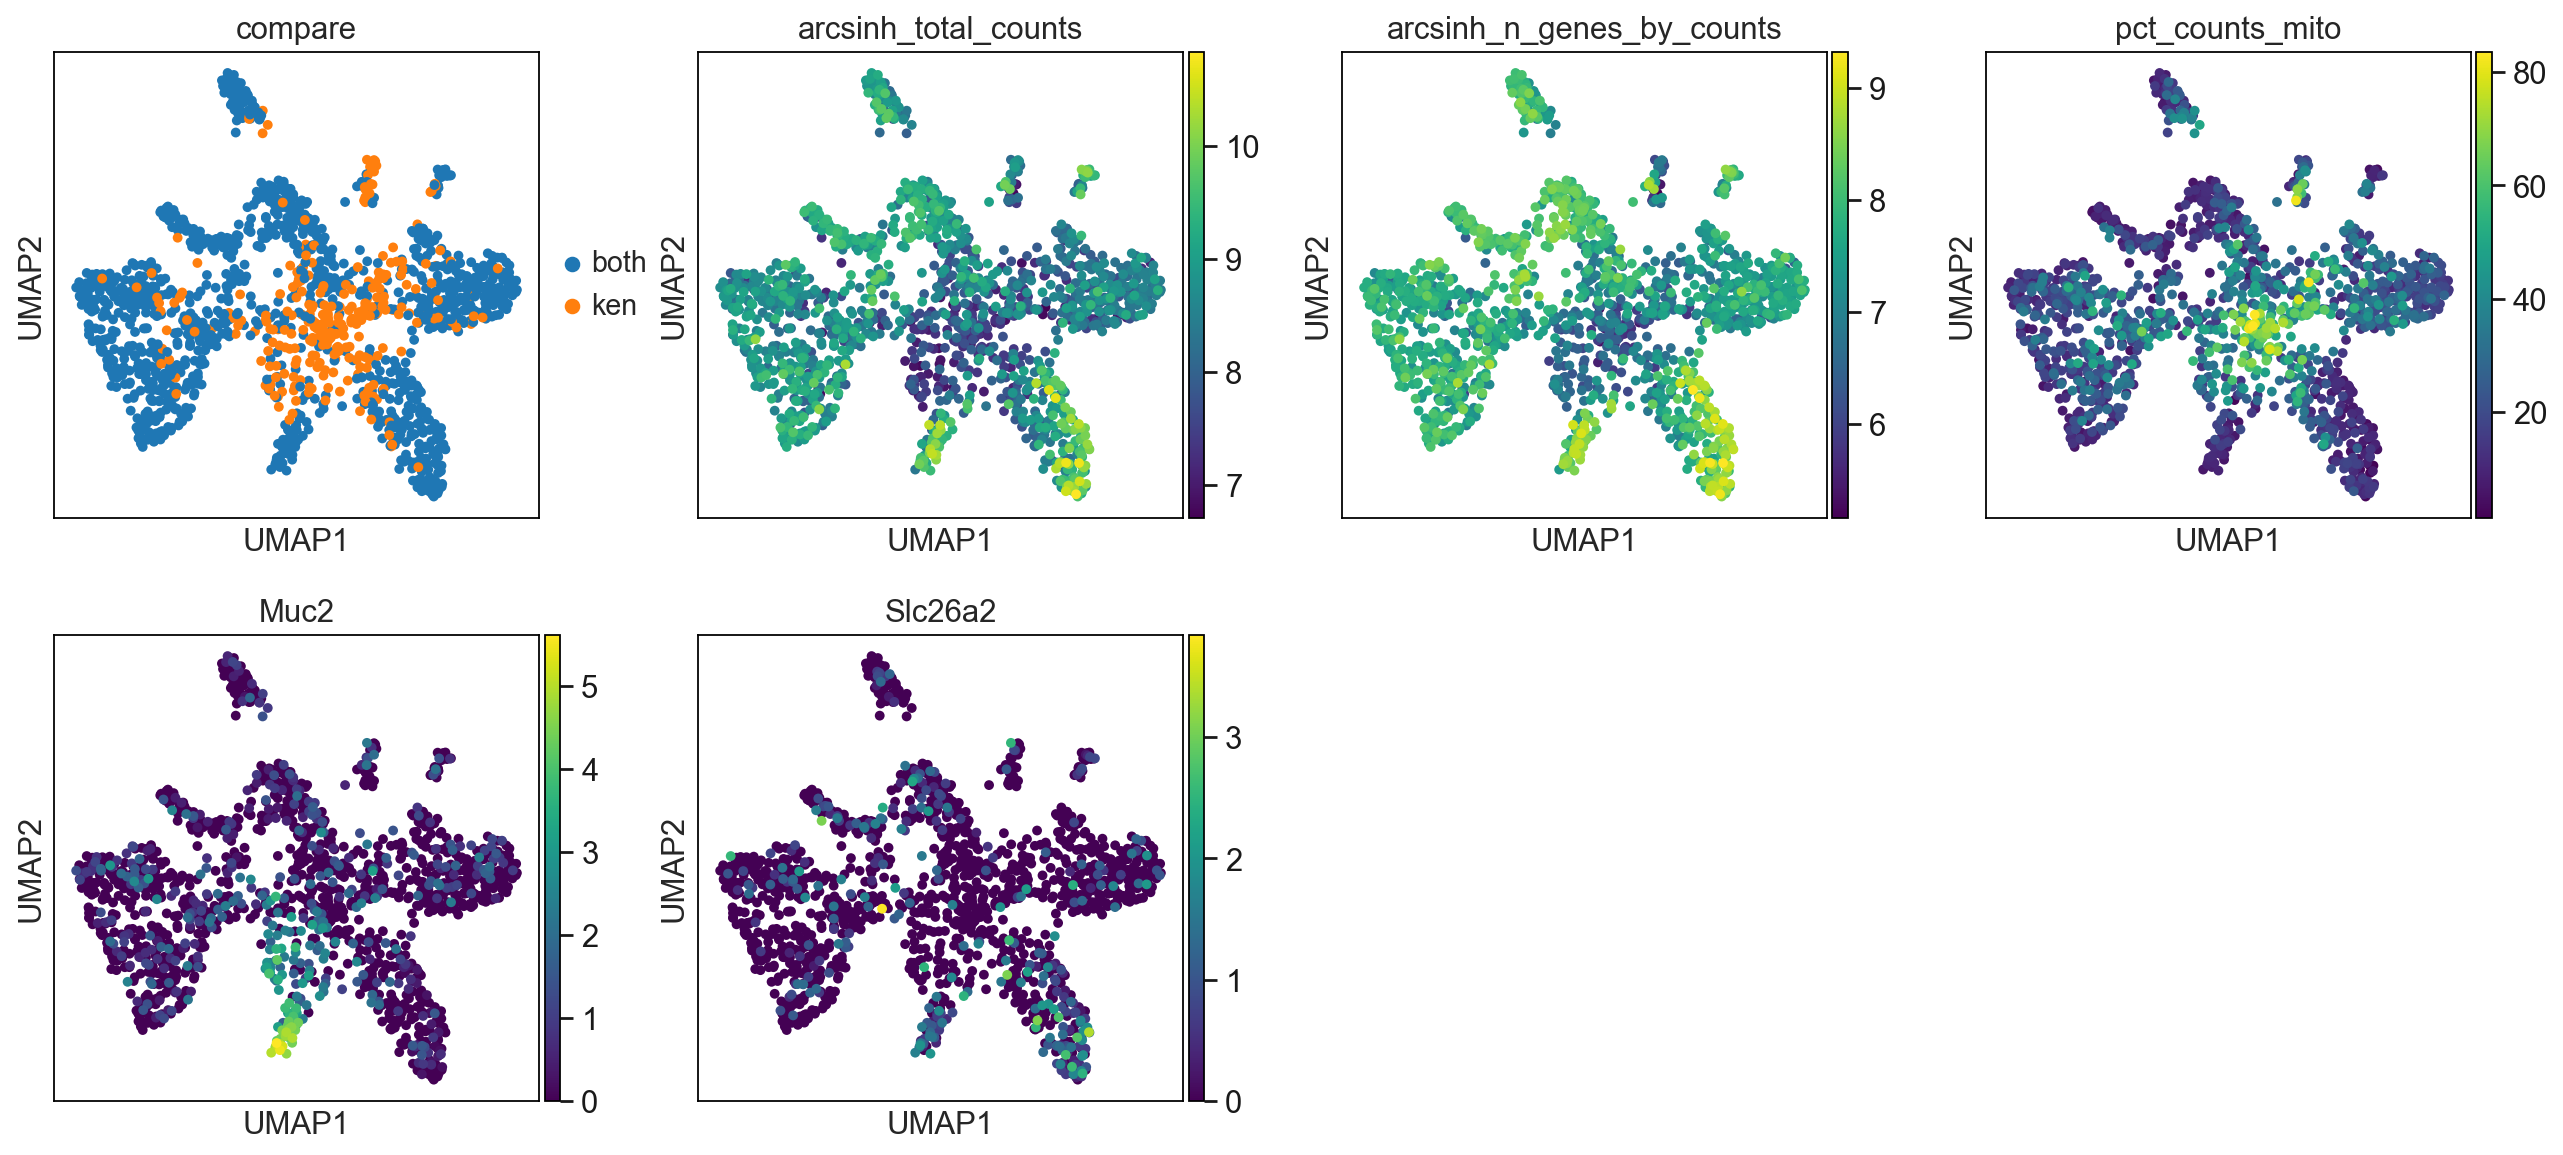

In [12]:
# show UMAP of Ken's data and look at difference from TwoStep
sc.pl.umap(s1_ken, color=['compare','arcsinh_total_counts','arcsinh_n_genes_by_counts','pct_counts_mito','Muc2','Slc26a2'])

---
#### Now do the same on TwoStep results

In [13]:
# preprocess
s1_twostep.X = s1_twostep.layers['raw_counts'].copy()
sc.pp.filter_genes(s1_twostep, min_cells=1)
recipe_fcc(s1_twostep, X_final='arcsinh_norm', mito_names='^mt-')
s1_twostep.obs['arcsinh_n_genes_by_counts'] = np.arcsinh(s1_twostep.obs['n_genes_by_counts'])

... storing 'compare' as categorical


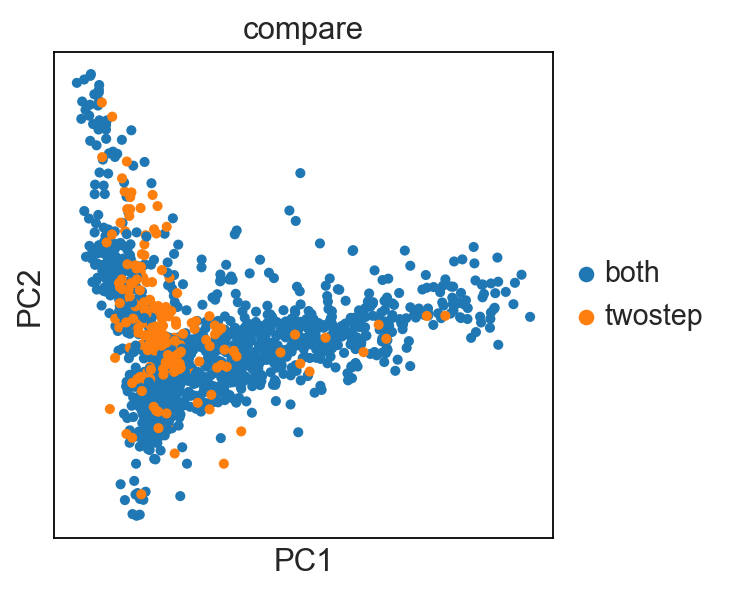

CPU times: user 1.45 s, sys: 249 ms, total: 1.7 s
Wall time: 272 ms


In [14]:
%%time
sc.tl.pca(s1_twostep, n_comps=10)
sc.pl.pca(s1_twostep, color=['compare'])

In [15]:
sc.pp.neighbors(s1_twostep, n_neighbors=int(np.sqrt(s1_twostep.n_obs)))
sc.tl.umap(s1_twostep)

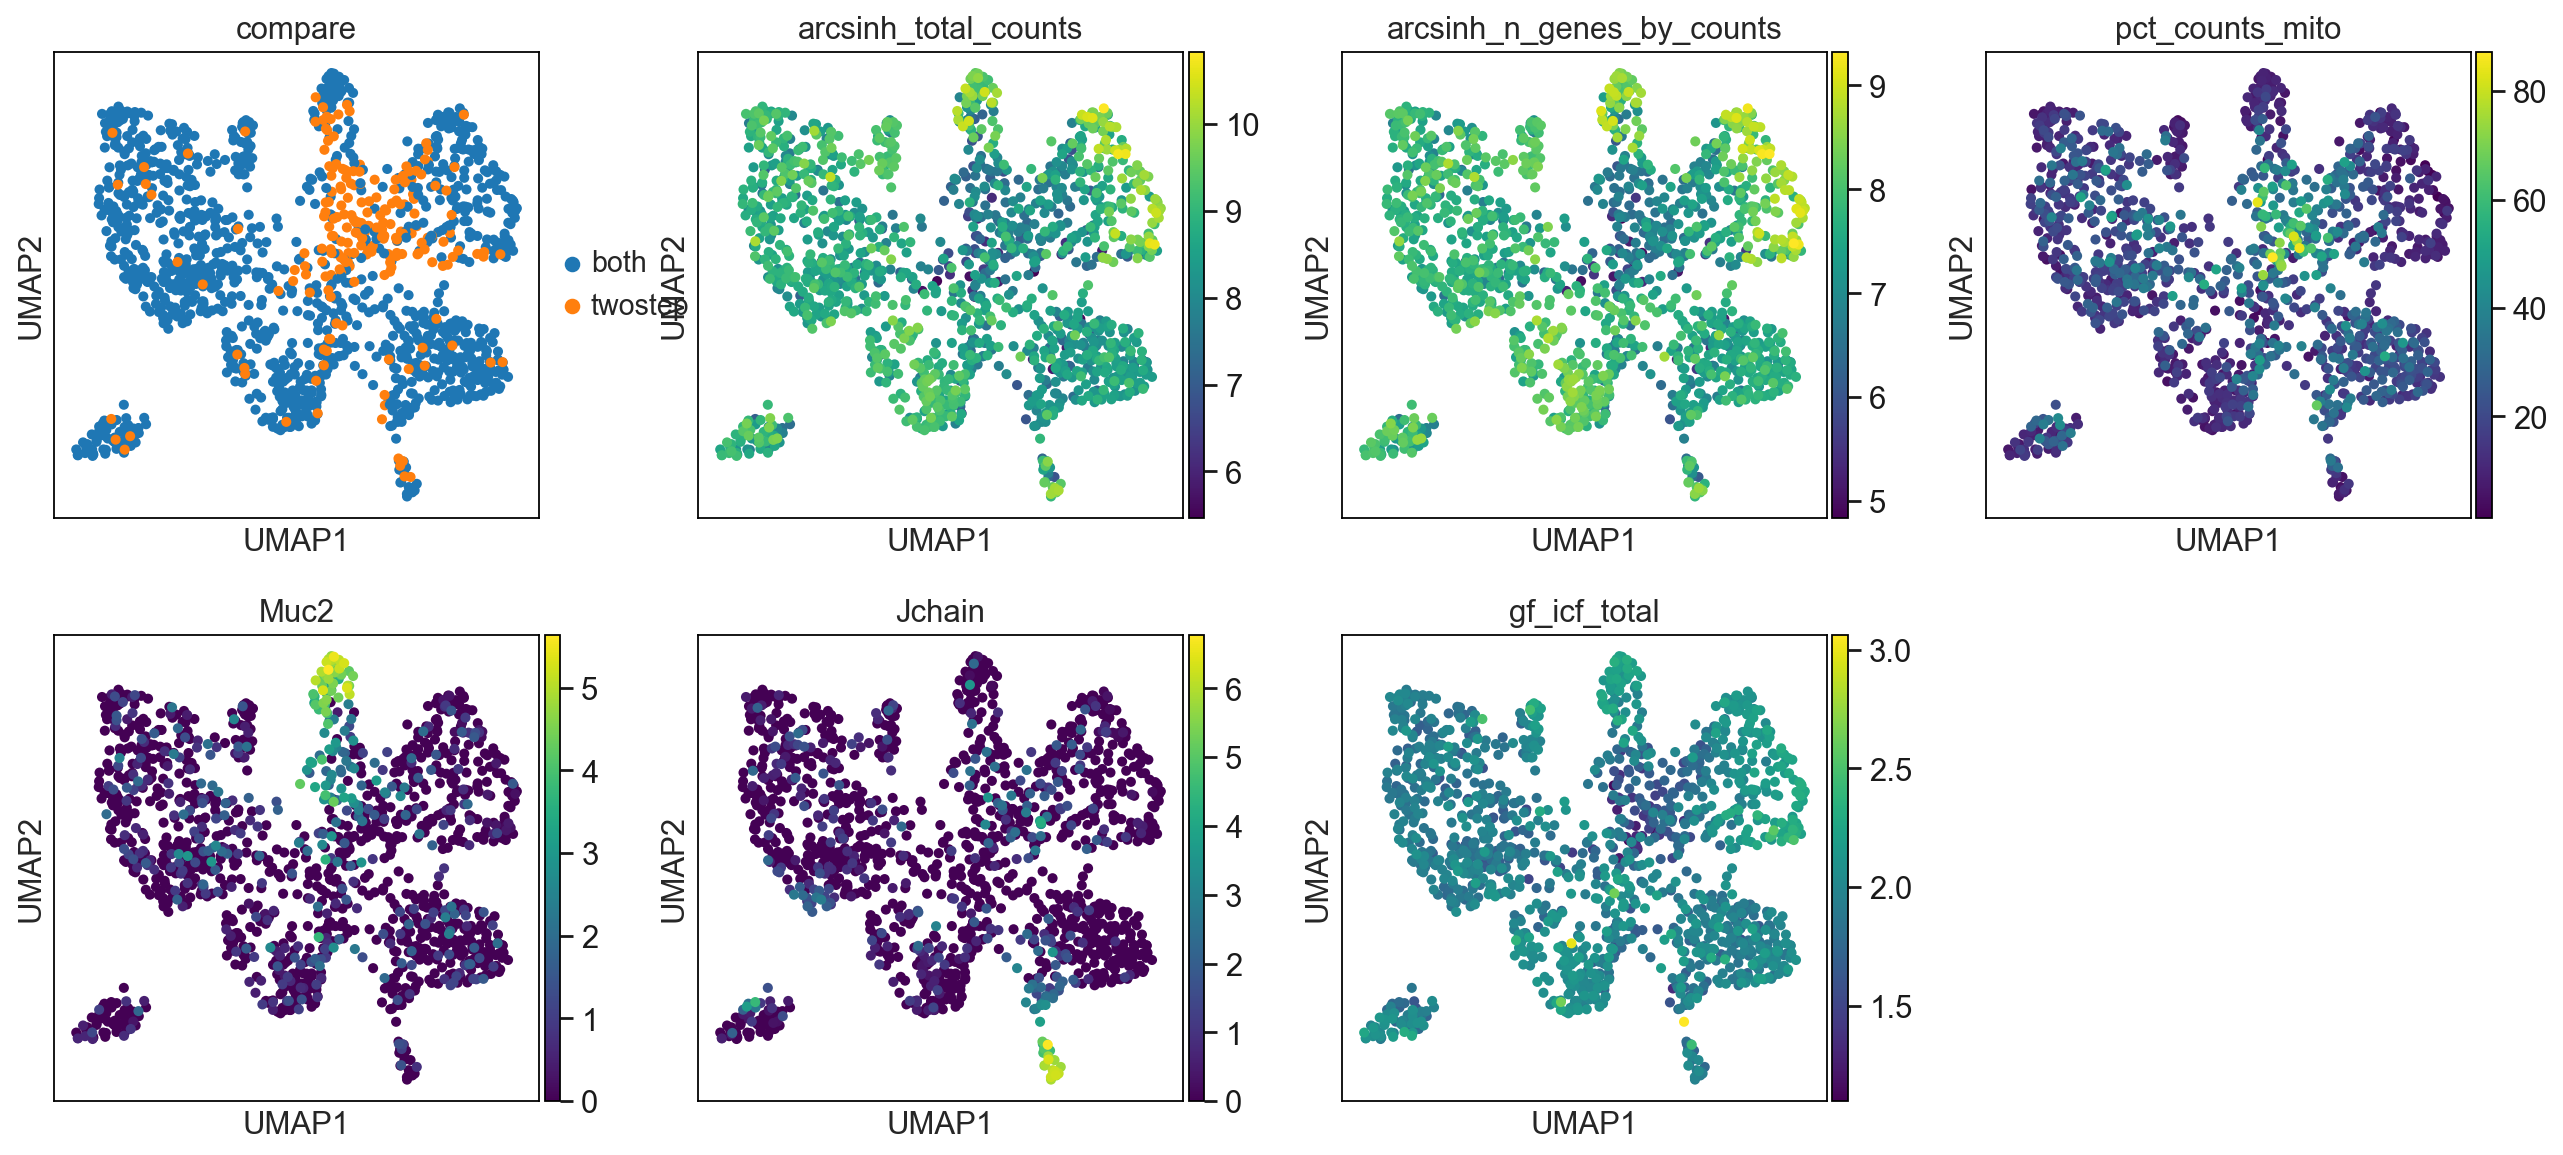

In [16]:
sc.pl.umap(s1_twostep, color=['compare','arcsinh_total_counts','arcsinh_n_genes_by_counts','pct_counts_mito','Muc2','Jchain','gf_icf_total'])